In [1]:
# %% [markdown]
# # 🌳 Эксперименты с деревом управлений
# 
# Этот notebook для интерактивных экспериментов с `ControlTreeBuilder`.
# 
# **Файл:** `spores/v14_back/notebooks/control_tree_experiments.ipynb`

# %% [markdown]
# ## 1. Импорты и настройка

# %%
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from IPython.display import display, HTML

In [2]:
current_dir = os.getcwd()
# Поднимаемся от текущей директории до spores/v14_back/src
project_root = os.path.abspath(os.path.join(current_dir, '..', '..', '..', 'src'))
if project_root not in sys.path:
    sys.path.append(project_root)

from logic.pendulum import PendulumSystem
from logic.control_tree import ControlTreeBuilder

# Настройка matplotlib для Jupyter
%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['figure.dpi'] = 100

print("✅ Модули загружены")

# %% [markdown]
# ## 2. Вспомогательные функции визуализации


✅ Модули загружены


In [3]:
def plot_dt_sensitivity(pendulum, initial_pos, dt_variations):
    """Анализ чувствительности к изменению dt."""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, dt_scale in enumerate(dt_variations):
        if i >= 6:
            break
            
        # Создаем dt_vector с масштабированием
        dt_vector = np.ones(8) * 0.1 * dt_scale
        
        # Строим дерево
        builder = ControlTreeBuilder(pendulum, dt_vector)
        tree_data = builder.build_tree(initial_pos)
        
        # Визуализируем
        plot_phase_space(tree_data, axes[i])
        axes[i].set_title(f'dt scale = {dt_scale:.2f}', fontsize=10)
    
    plt.suptitle('Sensitivity to dt variations', fontsize=14, fontweight='bold')
    plt.tight_layout()
    return fig

In [19]:
# %%
def plot_phase_space(tree_data, ax=None):
    """Рисует траектории в фазовом пространстве."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))
    
    nodes = tree_data['nodes']
    edges = tree_data['edges']
    
    # Настройка осей
    ax.set_xlabel('θ (angle)', fontsize=12)
    ax.set_ylabel('θ̇ (angular velocity)', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.set_title('Phase Space Trajectories', fontsize=14, fontweight='bold')
    
    # Рисуем траектории
    for edge in edges:
        parent = nodes[edge.parent_id]
        child = nodes[edge.child_id]
        
        # Цвет зависит от направления времени
        color = 'red' if edge.is_forward else 'blue'
        alpha = 0.7 if parent.level == 0 else 0.5
        
        ax.arrow(parent.position_2d[0], parent.position_2d[1],
                child.position_2d[0] - parent.position_2d[0],
                child.position_2d[1] - parent.position_2d[1],
                head_width=0.0001, head_length=0.0001,
                width=0.00001,
                fc=color, ec=color, alpha=alpha,
                length_includes_head=True)
    
    # Отмечаем узлы
    for level in [0, 1, 2]:
        level_nodes = [n for n in nodes.values() if n.level == level]
        if level_nodes:
            positions = np.array([n.position_2d for n in level_nodes])
            size = 200 - level * 50
            ax.scatter(positions[:, 0], positions[:, 1],
                      s=size, alpha=0.8, 
                      edgecolors='black', linewidth=1,
                      label=f'Level {level}', zorder=3)
    
    
    ax.legend()
    return ax


In [20]:
def create_graph_from_tree_data(tree_data):
    """Создает networkx.Graph из tree_data."""
    G = nx.DiGraph()  # Используем DiGraph для направленного графа
    
    # Добавляем узлы
    for node_id, node in tree_data['nodes'].items():
        G.add_node(node_id, pos=node.position_2d, level=node.level)
    
    # Добавляем рёбра
    for edge in tree_data['edges']:
        G.add_edge(edge.parent_id, edge.child_id, 
                  control=edge.control, 
                  dt=edge.dt, 
                  is_forward=edge.is_forward)
    
    return G


In [21]:
pendulum = PendulumSystem(
    g=9.81,
    l=2.0, 
    m=1.0,
    damping=0.1,
    max_control=2.0
)

print(f"📐 Система маятника:")
print(f"   Управление: [{-pendulum.max_control:.1f}, {pendulum.max_control:.1f}]")
print(f"   Демпфирование: {pendulum.damping}")

# %%
# Базовое дерево с одинаковыми dt
builder = ControlTreeBuilder(pendulum, dt_vector=np.ones(8) * 0.1)
initial_position = np.array([0.0+np.pi, 0.0])

print(f"🌱 Начальная позиция: θ={initial_position[0]:.2f}, θ̇={initial_position[1]:.2f}")
print(f"⏱️ dt_vector: {builder.dt_vector}")
print("\n" + "="*50)

📐 Система маятника:
   Управление: [-2.0, 2.0]
   Демпфирование: 0.1
🌱 Начальная позиция: θ=3.14, θ̇=0.00
⏱️ dt_vector: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]



In [22]:
builder = ControlTreeBuilder(pendulum, dt_vector=np.ones(8) * 0.01)
initial_position = np.array([np.pi, 0.0])
tree_data = builder.build_tree(initial_position)

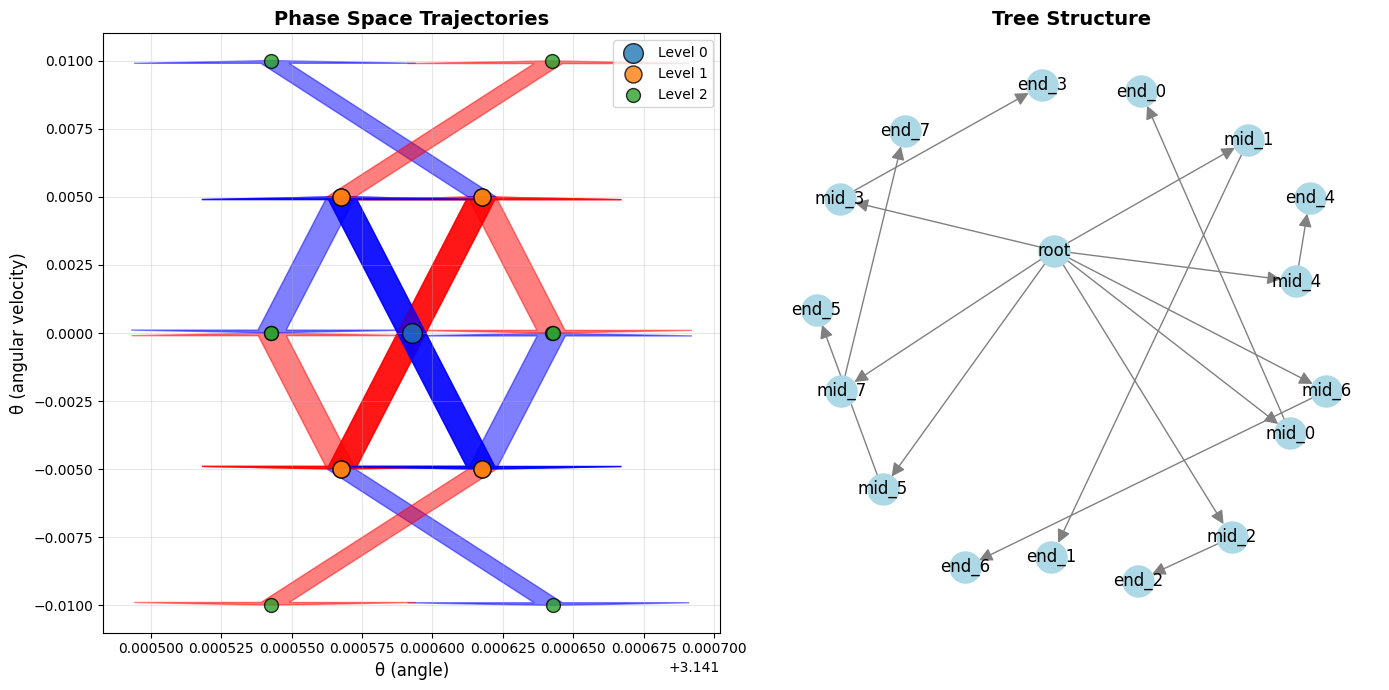

In [23]:
# Визуализация базового дерева
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# Фазовое пространство
plot_phase_space(tree_data, ax1)

# Граф структуры
ax2.set_title('Tree Structure', fontsize=14, fontweight='bold')

# Создаем граф
graph = create_graph_from_tree_data(tree_data)

# Теперь можно использовать nx.spring_layout
pos = nx.spring_layout(graph, k=2, iterations=50)

nx.draw(graph, pos, ax=ax2,
        with_labels=True, node_size=500,
        node_color='lightblue', edge_color='gray',
        arrows=True, arrowsize=20)

plt.tight_layout()
plt.show()


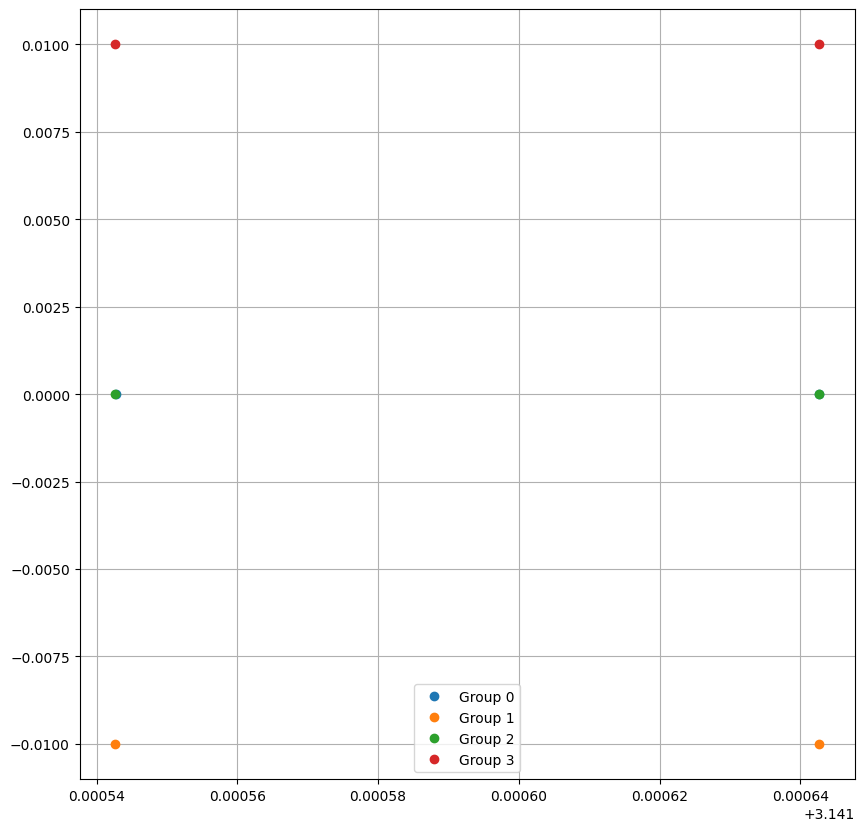

In [24]:
plt.figure(figsize=(10, 10))
deltas = []
weights = np.array([1, 1])
for i in range(4):
    end_points = tree_data['convergence_info']['groups'][i]['endpoints']
    delta_v = end_points[0] - end_points[1]
    delta_n = np.sqrt(delta_v**2 @ weights)
    # deltas.append(delta_n)
    # print(i)
    # print(end_points)
    # print(delta_v)
    # print(delta_v**2 @ weights)
    # print(delta_n)

    # if i in (0, 2):
    plt.plot(end_points[0][0], end_points[0][1], 'o', color=f'C{i}')
    plt.plot(end_points[1][0], end_points[1][1], 'o', color=f'C{i}', label=f'Group {i}')

plt.grid()
plt.legend()
# plt.axis('equal')

In [10]:
end_points_lst = [tree_data['convergence_info']['groups'][i]['endpoints'] for i in range(4)]
end_points_lst = np.array(end_points_lst)
# print(end_points_lst)
# print('-'*100)

buf_1 = end_points_lst[::2].copy()
buf_2 = buf_1.copy()

buf_2[0, 1] = buf_1[1, 0]
buf_2[1, 0] = buf_1[0, 1]

print(buf_1)
a = np.sqrt(((buf_1[0][0] - buf_1[0][1])**2).sum())
b = np.sqrt(((buf_1[1][0] - buf_1[1][1])**2).sum())
print(a)
print(b)
print(a+b)

print('-'*100)
print(buf_2)
a = np.sqrt(((buf_2[0][0] - buf_2[0][1])**2).sum())
b = np.sqrt(((buf_2[1][0] - buf_2[1][1])**2).sum())
print(a)
print(b)
print(a+b)

[[[ 3.14164262e+00 -2.54506189e-06]
  [ 3.14154269e+00  2.54506189e-06]]

 [[ 3.14164272e+00 -7.46066707e-06]
  [ 3.14154259e+00  7.46066707e-06]]]
0.00010005820368276177
0.00010123439272144963
0.0002012925964042114
----------------------------------------------------------------------------------------------------
[[[ 3.14164262e+00 -2.54506189e-06]
  [ 3.14164272e+00 -7.46066707e-06]]

 [[ 3.14154269e+00  2.54506189e-06]
  [ 3.14154259e+00  7.46066707e-06]]]
4.916622749030402e-06
4.916622749075495e-06
9.833245498105896e-06


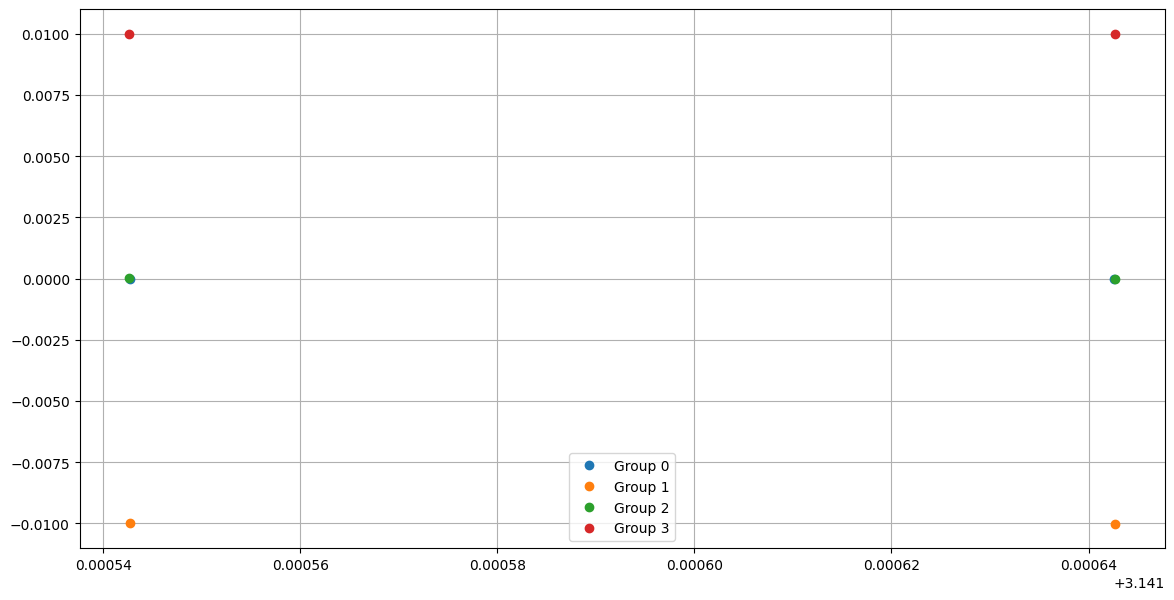

In [11]:
deltas = []
weights = np.array([1, 1])
for i in range(4):
    end_points = tree_data['convergence_info']['groups'][i]['endpoints']
    delta_v = end_points[0] - end_points[1]
    delta_n = np.sqrt(delta_v**2 @ weights)
    # deltas.append(delta_n)
    # print(i)
    # print(end_points)
    # print(delta_v)
    # print(delta_v**2 @ weights)
    # print(delta_n)

    plt.plot(end_points[0][0], end_points[0][1], 'o', color=f'C{i}')
    plt.plot(end_points[1][0], end_points[1][1], 'o', color=f'C{i}', label=f'Group {i}')

plt.grid()
plt.legend()

In [12]:
deltas = np.zeros(4)
a

4.916622749030402e-06

In [13]:
deltas = []
weights = np.array([1, 1])
for i in range(4):
    end_points = tree_data['convergence_info']['groups'][i]['endpoints']
    delta_v = end_points[0] - end_points[1]
    delta_n = np.sqrt(delta_v**2 @ weights)
    deltas.append(delta_n)
    print(i)
    print(end_points)
    print(delta_v)
    print(delta_v**2 @ weights)
    print(delta_n)

endpoints

deltas = np.array(deltas)
deltas

0
[array([ 3.14164262e+00, -2.54506189e-06]), array([3.14154269e+00, 2.54506189e-06])]
[ 9.99286484e-05 -5.09012377e-06]
1.001164412422104e-08
0.00010005820368276177
1
[array([ 3.14164267, -0.01000582]), array([ 3.14154267, -0.00999582])]
[ 1.00004096e-04 -1.00008184e-05]
1.0100835564569926e-08
0.00010050291321434382
2
[array([ 3.14164272e+00, -7.46066707e-06]), array([3.14154259e+00, 7.46066707e-06])]
[ 1.00128697e-04 -1.49213341e-05]
1.0248402269680692e-08
0.00010123439272144963
3
[array([3.14154263, 0.01000582]), array([3.14164264, 0.00999582])]
[-1.00004096e-04  1.00008184e-05]
1.0100835564569996e-08
0.00010050291321434417


NameError: name 'endpoints' is not defined

In [ ]:

# %% [markdown]
# ## 4. Эксперимент со схождением траекторий

# %%
# Настраиваем dt для лучшего схождения
# Идея: малые dt для точного схождения
convergence_dt = np.array([
    0.05, 0.05, 0.05, 0.05,  # Уровень 1: малые шаги
    0.05, 0.05, 0.05, 0.05   # Уровень 2: тоже малые
])

builder_conv = ControlTreeBuilder(pendulum, convergence_dt)
tree_conv = builder_conv.build_tree(initial_position)

print("\n📊 Статистика схождения:")
conv_info = tree_conv['convergence_info']
print(f"   Уникальных позиций: {conv_info['unique_positions']}")
print(f"   Точек схождения: {conv_info['convergent_points']}")

# %%
# Визуализация схождения
plt.figure(figsize=(10, 10))
plot_phase_space(tree_conv)
plt.title('Convergence with small dt = 0.05', fontsize=14, fontweight='bold')
plt.show()

# %% [markdown]
# ## 5. Анализ чувствительности к dt

# %%
# Исследуем влияние масштаба dt
dt_scales = [0.5, 0.75, 1.0, 1.25, 1.5, 2.0]
fig = plot_dt_sensitivity(pendulum, initial_position, dt_scales)
plt.show()

# %% [markdown]
# ## 6. Оптимизация dt для минимизации расстояния до цели

# %%
def objective_function(dt_vector, pendulum, initial_pos, goal_pos):
    """Целевая функция: минимум расстояния листьев до цели."""
    builder = ControlTreeBuilder(pendulum, np.abs(dt_vector))  # Обеспечиваем положительные dt
    tree = builder.build_tree(initial_pos)
    
    # Получаем позиции листьев
    leaf_positions = builder.get_all_leaf_positions()
    
    # Вычисляем среднее расстояние до цели
    distances = [np.linalg.norm(pos - goal_pos) for pos in leaf_positions]
    return np.mean(distances)

# Простая оптимизация методом случайного поиска
goal_position = np.array([0.0, 0.0])
best_dt = None
best_cost = float('inf')

print("🎯 Цель: θ=0, θ̇=0")
print("🔍 Оптимизация dt методом случайного поиска...")

for i in range(20):
    # Генерируем случайный dt_vector
    random_dt = np.random.uniform(0.01, 0.2, 8)
    
    # Вычисляем стоимость
    cost = objective_function(random_dt, pendulum, initial_position, goal_position)
    
    if cost < best_cost:
        best_cost = cost
        best_dt = random_dt
        print(f"   Итерация {i+1}: улучшение! cost = {cost:.4f}")

print(f"\n✅ Лучший результат: cost = {best_cost:.4f}")
print(f"   dt_vector = {best_dt}")

# %%
# Визуализация оптимизированного дерева
builder_opt = ControlTreeBuilder(pendulum, best_dt)
tree_opt = builder_opt.build_tree(initial_position)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# Фазовое пространство с целью
plot_phase_space(tree_opt, ax1)
ax1.scatter(*goal_position, s=300, c='green', marker='*', 
           edgecolors='black', linewidth=2, label='Goal', zorder=5)
ax1.legend()

# Сравнение dt векторов
ax2.bar(range(8), builder.dt_vector, alpha=0.5, label='Default')
ax2.bar(range(8), best_dt, alpha=0.5, label='Optimized')
ax2.set_xlabel('dt index')
ax2.set_ylabel('dt value')
ax2.set_title('dt vectors comparison')
ax2.legend()

plt.tight_layout()
plt.show()

# %% [markdown]
# ## 7. Интерактивный эксперимент

# %%
from ipywidgets import interact, FloatSlider, VBox
import ipywidgets as widgets

def interactive_tree(dt0=0.1, dt1=0.1, dt2=0.1, dt3=0.1,
                    dt4=0.1, dt5=0.1, dt6=0.1, dt7=0.1):
    """Интерактивное изменение dt."""
    dt_vector = np.array([dt0, dt1, dt2, dt3, dt4, dt5, dt6, dt7])
    
    builder = ControlTreeBuilder(pendulum, dt_vector)
    tree = builder.build_tree(initial_position)
    
    plt.figure(figsize=(10, 10))
    plot_phase_space(tree)
    plt.title(f'Interactive Control Tree\nConvergent points: {tree["convergence_info"]["convergent_points"]}')
    plt.show()

# Создаем слайдеры
dt_sliders = [FloatSlider(min=0.01, max=0.3, step=0.01, value=0.1, 
                          description=f'dt{i}') for i in range(8)]

# Интерактивный виджет
interact(interactive_tree, 
         dt0=dt_sliders[0], dt1=dt_sliders[1], 
         dt2=dt_sliders[2], dt3=dt_sliders[3],
         dt4=dt_sliders[4], dt5=dt_sliders[5],
         dt6=dt_sliders[6], dt7=dt_sliders[7])

# %% [markdown]
# ## 8. Сохранение результатов

# %%
# Сохраняем лучшую конфигурацию
import json

best_config = {
    'dt_vector': best_dt.tolist(),
    'cost': float(best_cost),
    'initial_position': initial_position.tolist(),
    'goal_position': goal_position.tolist(),
    'convergence_info': {
        'unique_positions': tree_opt['convergence_info']['unique_positions'],
        'convergent_points': tree_opt['convergence_info']['convergent_points']
    }
}

# Сохраняем в файл (опционально)
# with open('../config/json/optimized_tree_config.json', 'w') as f:
#     json.dump(best_config, f, indent=2)

print("📊 Конфигурация для сохранения:")
print(json.dumps(best_config, indent=2))

# %% [markdown]
# ## Выводы
# 
# 1. **Схождение траекторий** достигается при малых значениях dt
# 2. **Оптимизация dt** позволяет улучшить достижение цели
# 3. **Структура дерева** зависит от соотношения dt для прямых и обратных переходов
# 
# ### Следующие шаги:
# - Интеграция `ControlTreeBuilder` в `ManualSporeManager`
# - Добавление визуализации дерева в 3D сцену
# - Подключение оптимизатора для автоматической настройки dt


📊 Статистика схождения:


KeyError: 'unique_positions'

In [ ]:
# Настройка matplotlib для Jupyter
%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['figure.dpi'] = 100

print("✅ Модули загружены")

# %% [markdown]
# ## 2. Вспомогательные функции визуализации

# %%
def plot_phase_space(tree_data, ax=None):
    """Рисует траектории в фазовом пространстве."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))
    
    nodes = tree_data['nodes']
    edges = tree_data['edges']
    
    # Настройка осей
    ax.set_xlabel('θ (angle)', fontsize=12)
    ax.set_ylabel('θ̇ (angular velocity)', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.set_title('Phase Space Trajectories', fontsize=14, fontweight='bold')
    
    # Рисуем траектории
    for edge in edges:
        parent = nodes[edge.parent_id]
        child = nodes[edge.child_id]
        
        # Цвет зависит от направления времени
        color = 'blue' if edge.is_forward else 'red'
        alpha = 0.7 if parent.level == 0 else 0.5
        
        ax.arrow(parent.position_2d[0], parent.position_2d[1],
                child.position_2d[0] - parent.position_2d[0],
                child.position_2d[1] - parent.position_2d[1],
                head_width=0.02, head_length=0.03,
                fc=color, ec=color, alpha=alpha,
                length_includes_head=True)
    
    # Отмечаем узлы
    for level in [0, 1, 2]:
        level_nodes = [n for n in nodes.values() if n.level == level]
        if level_nodes:
            positions = np.array([n.position_2d for n in level_nodes])
            size = 200 - level * 50
            ax.scatter(positions[:, 0], positions[:, 1],
                      s=size, alpha=0.8, 
                      edgecolors='black', linewidth=1,
                      label=f'Level {level}', zorder=3)
    
    # Выделяем точки схождения
    for pos in tree_data['convergence_info']['convergent_details'].keys():
        circle = plt.Circle(pos, 0.04, fill=False,
                          edgecolor='purple', linewidth=2,
                          linestyle='--')
        ax.add_patch(circle)
    
    ax.legend()
    return ax

def plot_dt_sensitivity(pendulum, initial_pos, dt_variations):
    """Анализ чувствительности к изменению dt."""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, dt_scale in enumerate(dt_variations):
        if i >= 6:
            break
            
        # Создаем dt_vector с масштабированием
        dt_vector = np.ones(8) * 0.1 * dt_scale
        
        # Строим дерево
        builder = ControlTreeBuilder(pendulum, dt_vector)
        tree_data = builder.build_tree(initial_pos)
        
        # Визуализируем
        plot_phase_space(tree_data, axes[i])
        axes[i].set_title(f'dt scale = {dt_scale:.2f}', fontsize=10)
    
    plt.suptitle('Sensitivity to dt variations', fontsize=14, fontweight='bold')
    plt.tight_layout()
    return fig

# %% [markdown]
# ## 3. Создание системы и базовый эксперимент

# %%
# Создаем систему маятника
pendulum = PendulumSystem(
    g=9.81,
    l=2.0, 
    m=1.0,
    damping=0.1,
    max_control=2.0
)

print(f"📐 Система маятника:")
print(f"   Управление: [{-pendulum.u_max:.1f}, {pendulum.u_max:.1f}]")
print(f"   Демпфирование: {pendulum.damping}")

# %%
# Базовое дерево с одинаковыми dt
builder = ControlTreeBuilder(pendulum)
initial_position = np.array([0.5, 0.0])

print(f"🌱 Начальная позиция: θ={initial_position[0]:.2f}, θ̇={initial_position[1]:.2f}")
print(f"⏱️ dt_vector: {builder.dt_vector}")
print("\n" + "="*50)

tree_data = builder.build_tree(initial_position)

# %%
# Визуализация базового дерева
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# Фазовое пространство
plot_phase_space(tree_data, ax1)

# Граф структуры
ax2.set_title('Tree Structure', fontsize=14, fontweight='bold')
pos = nx.spring_layout(tree_data['graph'], k=2, iterations=50)
nx.draw(tree_data['graph'], pos, ax=ax2,
        with_labels=True, node_size=500,
        node_color='lightblue', edge_color='gray',
        arrows=True, arrowsize=20)

plt.tight_layout()
plt.show()

# %% [markdown]
# ## 4. Эксперимент со схождением траекторий

# %%
# Настраиваем dt для лучшего схождения
# Идея: малые dt для точного схождения
convergence_dt = np.array([
    0.05, 0.05, 0.05, 0.05,  # Уровень 1: малые шаги
    0.05, 0.05, 0.05, 0.05   # Уровень 2: тоже малые
])

builder_conv = ControlTreeBuilder(pendulum, convergence_dt)
tree_conv = builder_conv.build_tree(initial_position)

print("\n📊 Статистика схождения:")
conv_info = tree_conv['convergence_info']
print(f"   Уникальных позиций: {conv_info['unique_positions']}")
print(f"   Точек схождения: {conv_info['convergent_points']}")

# %%
# Визуализация схождения
plt.figure(figsize=(10, 10))
plot_phase_space(tree_conv)
plt.title('Convergence with small dt = 0.05', fontsize=14, fontweight='bold')
plt.show()

# %% [markdown]
# ## 5. Анализ чувствительности к dt

# %%
# Исследуем влияние масштаба dt
dt_scales = [0.5, 0.75, 1.0, 1.25, 1.5, 2.0]
fig = plot_dt_sensitivity(pendulum, initial_position, dt_scales)
plt.show()

# %% [markdown]
# ## 6. Оптимизация dt для минимизации расстояния до цели

# %%
def objective_function(dt_vector, pendulum, initial_pos, goal_pos):
    """Целевая функция: минимум расстояния листьев до цели."""
    builder = ControlTreeBuilder(pendulum, np.abs(dt_vector))  # Обеспечиваем положительные dt
    tree = builder.build_tree(initial_pos)
    
    # Получаем позиции листьев
    leaf_positions = builder.get_all_leaf_positions()
    
    # Вычисляем среднее расстояние до цели
    distances = [np.linalg.norm(pos - goal_pos) for pos in leaf_positions]
    return np.mean(distances)

# Простая оптимизация методом случайного поиска
goal_position = np.array([0.0, 0.0])
best_dt = None
best_cost = float('inf')

print("🎯 Цель: θ=0, θ̇=0")
print("🔍 Оптимизация dt методом случайного поиска...")

for i in range(20):
    # Генерируем случайный dt_vector
    random_dt = np.random.uniform(0.01, 0.2, 8)
    
    # Вычисляем стоимость
    cost = objective_function(random_dt, pendulum, initial_position, goal_position)
    
    if cost < best_cost:
        best_cost = cost
        best_dt = random_dt
        print(f"   Итерация {i+1}: улучшение! cost = {cost:.4f}")

print(f"\n✅ Лучший результат: cost = {best_cost:.4f}")
print(f"   dt_vector = {best_dt}")

# %%
# Визуализация оптимизированного дерева
builder_opt = ControlTreeBuilder(pendulum, best_dt)
tree_opt = builder_opt.build_tree(initial_position)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# Фазовое пространство с целью
plot_phase_space(tree_opt, ax1)
ax1.scatter(*goal_position, s=300, c='green', marker='*', 
           edgecolors='black', linewidth=2, label='Goal', zorder=5)
ax1.legend()

# Сравнение dt векторов
ax2.bar(range(8), builder.dt_vector, alpha=0.5, label='Default')
ax2.bar(range(8), best_dt, alpha=0.5, label='Optimized')
ax2.set_xlabel('dt index')
ax2.set_ylabel('dt value')
ax2.set_title('dt vectors comparison')
ax2.legend()

plt.tight_layout()
plt.show()

# %% [markdown]
# ## 7. Интерактивный эксперимент

# %%
from ipywidgets import interact, FloatSlider, VBox
import ipywidgets as widgets

def interactive_tree(dt0=0.1, dt1=0.1, dt2=0.1, dt3=0.1,
                    dt4=0.1, dt5=0.1, dt6=0.1, dt7=0.1):
    """Интерактивное изменение dt."""
    dt_vector = np.array([dt0, dt1, dt2, dt3, dt4, dt5, dt6, dt7])
    
    builder = ControlTreeBuilder(pendulum, dt_vector)
    tree = builder.build_tree(initial_position)
    
    plt.figure(figsize=(10, 10))
    plot_phase_space(tree)
    plt.title(f'Interactive Control Tree\nConvergent points: {tree["convergence_info"]["convergent_points"]}')
    plt.show()

# Создаем слайдеры
dt_sliders = [FloatSlider(min=0.01, max=0.3, step=0.01, value=0.1, 
                          description=f'dt{i}') for i in range(8)]

# Интерактивный виджет
interact(interactive_tree, 
         dt0=dt_sliders[0], dt1=dt_sliders[1], 
         dt2=dt_sliders[2], dt3=dt_sliders[3],
         dt4=dt_sliders[4], dt5=dt_sliders[5],
         dt6=dt_sliders[6], dt7=dt_sliders[7])

# %% [markdown]
# ## 8. Сохранение результатов

# %%
# Сохраняем лучшую конфигурацию
import json

best_config = {
    'dt_vector': best_dt.tolist(),
    'cost': float(best_cost),
    'initial_position': initial_position.tolist(),
    'goal_position': goal_position.tolist(),
    'convergence_info': {
        'unique_positions': tree_opt['convergence_info']['unique_positions'],
        'convergent_points': tree_opt['convergence_info']['convergent_points']
    }
}

# Сохраняем в файл (опционально)
# with open('../config/json/optimized_tree_config.json', 'w') as f:
#     json.dump(best_config, f, indent=2)

print("📊 Конфигурация для сохранения:")
print(json.dumps(best_config, indent=2))

# %% [markdown]
# ## Выводы
# 
# 1. **Схождение траекторий** достигается при малых значениях dt
# 2. **Оптимизация dt** позволяет улучшить достижение цели
# 3. **Структура дерева** зависит от соотношения dt для прямых и обратных переходов
# 
# ### Следующие шаги:
# - Интеграция `ControlTreeBuilder` в `ManualSporeManager`
# - Добавление визуализации дерева в 3D сцену
# - Подключение оптимизатора для автоматической настройки dt

✅ Модули загружены
📐 Система маятника:


AttributeError: 'PendulumSystem' object has no attribute 'u_max'